In [1]:
#import library
import numpy as np
import pandas as pd
from datetime import date
from neupy import algorithms
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import keras
from keras import regularizers
import pyrenn as prn
from keras.callbacks import EarlyStopping

c:\users\qqwea1223\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\qqwea1223\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\qqwea1223\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\user

In [2]:
file_parameters = ['ch', 'cv', 'cc']
plant_date = '0401'
limit_day = 105
interval_day = 7
x_pred = range(interval_day, limit_day+1, interval_day)
path = 'sigmoid_2016_spring/sigmoid_2016_spring{}.csv'
# sigmoi_2016_spring_ch.csv
yield_path = '2016_spring/2016_spring.csv'

In [14]:
parameter = 'ch'
term = pd.read_csv(path.format('_'+parameter))
term.head

<bound method NDFrame.head of      max_value  max_growth_rate  half_max_growth_rate  first_day_half_max  \
0     1.132855         0.027922              0.014146                42.0   
1     1.272441         0.028461              0.014705                35.0   
2     1.378696         0.030998              0.015933                37.0   
3     1.405654         0.032263              0.016535                38.0   
4     1.237971         0.030544              0.015534                39.0   
..         ...              ...                   ...                 ...   
797   0.938958         0.025537              0.012925                38.0   
798   1.008285         0.025323              0.012884                38.0   
799   1.020679         0.024877              0.012716                37.0   
800   1.116538         0.031972              0.016126                39.0   
801   0.822383         0.022021              0.011086                44.0   

     second_day_half_max  duration_half_max  

In [3]:
canopy_dataframe = pd.read_csv('2016_spring/2016_spring.csv')
akash_data = pd.read_excel('CH.xlsx', 'Sheet1')
index_mask = pd.read_excel('index_of_considered_samples.xlsx', 'Sheet1', header = None)

In [16]:
mask  = np.isin(canopy_dataframe['order'].values, index_mask.values) & (canopy_dataframe['Weight per row (lbs)'].values > 0)
# print(canopy_dataframe['order'].values.shape)
# print(index_mask.values.shape)
canopy_dataframe = canopy_dataframe[mask]
print(canopy_dataframe.shape)
print(sum(mask))
# print(canopy_dataframe.shape)
# # print(sum(mask_CH))
canopy_dataframe = canopy_dataframe.reset_index()

(802, 160)
802


In [4]:
original_data = canopy_dataframe.copy()

In [5]:
def cottonYieldData(parameters):
    x_normalization_mask = []
    processed_data = {}
    std = parameters['std']
    normalization = parameters['normalization']
    interval_day = parameters['interval_day']
    limit_day = parameters['limit_day']
    
    
    
    plant_date = '0401'
    file_parameters = parameters['file_parameters']
    
    for (i, parameter) in enumerate(file_parameters):
    #     print(type(data[parameter]))
        parameter_data = pd.read_csv(path.format('_'+parameter))
        print(parameter_data.shape)
        parameter_data = parameter_data.values
        if i == 0:
             interval_process_data = np.empty([len(parameter_data), 0])
        if normalization:
            x_normalization_mask.append(np.linalg.norm(parameter_data[:,:3]))
            x_normalization_mask.append(np.linalg.norm(parameter_data[:,3:]))
            parameter_data[:,:3] /= np.linalg.norm(parameter_data[:,:3])
            parameter_data[:,3:] /= np.linalg.norm(parameter_data[:,3:])
            
        interval_process_data = np.append(interval_process_data, parameter_data, axis = 1)
#     print(interval_process_data.shape)
    extra_parameters = data_parameters['extra_parameters']
    for parameter in extra_parameters:
        data = original_data[[x for x in original_data.columns if parameter in x]].copy().values.astype(float)
        x_normalization_mask.append(np.linalg.norm(data))
        data /= np.linalg.norm(data)
        interval_process_data = np.append(interval_process_data, data, axis = 1)
        
#     print(interval_process_data.shape)
    one_hot_encoded_parameters = data_parameters['one_hot_encoded_parameters']
     #Added one hot of irrigation
    for parameter in one_hot_encoded_parameters:
        irrigation = pd.DataFrame(original_data[parameter].copy())
        irrigation_values = np.unique(irrigation)
        irrigation[parameter] = irrigation[parameter].map(lambda x: {value:i for (i, value) in enumerate(irrigation_values)}.get(x))
        irrigation = pd.get_dummies(irrigation[parameter])
        interval_process_data = np.append(interval_process_data, irrigation.values, axis = 1)    
        
#     print(interval_process_data.shape)
#      #Added one hot of plantDate
#     test_plant_date = pd.DataFrame(yield_data['plantDate'])
#     test_plant_data_values = np.unique(yield_data['plantDate'].values)
#     test_plant_date['plantDate'] = test_plant_date['plantDate'].map(lambda x: {date:i for (i, date) in enumerate(test_plant_data_values)}.get(x))
#     test_plant_date = pd.get_dummies(test_plant_date['plantDate'])
#     interval_process_data = np.append(interval_process_data, test_plant_date.values, axis = 1)
    
        
    
    
    x_train = interval_process_data 
    y_train = original_data['Weight per row (lbs)'].copy().values
#     print(y_train.shape)
#     print(x_train.shape)
    

    y_normalization_mask = np.linalg.norm(y_train)
    if normalization:
        y_train /= y_normalization_mask

    return(x_train, y_train, x_normalization_mask, y_normalization_mask)


In [6]:
def process(model_parameters, data_parameters, data_func):
    
    x_data, y_data, x_normalization_mask, y_normalization_mask = data_func(data_parameters)
    print(x_data.shape)
    print(y_data.shape)
    return(trainModel(x_data, y_data, x_data.shape[1], model_parameters))

In [7]:
def akashModel(x_data, y_data, input_shape, model_parameter):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state = 90)
#     x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state = 90)
    x_train = x_train.T
    y_train = y_train.T
    x_test = x_test.T
    y_test = y_test.T
    layer_shape = model_parameters['layer']
    kmax = model_parameters['k_max']
    damp_const = model_parameters['dampconst']
    damp_fac = model_parameters['dampfac']
    E_stop = model_parameters['E_stop']
    verbose = model_parameters['verbose']

    net = prn.CreateNN(np.append(np.append(input_shape, layer_shape), 1))
    net = prn.train_LM(x_train, y_train, net, verbose=verbose,
    dampfac = damp_fac, dampconst = damp_const,
    k_max=kmax, E_stop= E_stop)
    
    y = prn.NNOut(x_train, net)
    y_pred = prn.NNOut(x_test, net)
    acc_sc_chk = pd.DataFrame({'y_train': y_train.flatten(), 'y_train_pred': y.flatten()})
    acc_sc_chk.head()
    r2_score_1 = r2_score(acc_sc_chk.y_train, acc_sc_chk.y_train_pred)
    print('r2 score = ', r2_score_1, '/ 1.0')

    acc_sc_chk_2 = pd.DataFrame({'y_test': y_test.flatten(), 'y_test_pred': y_pred.flatten()})
    acc_sc_chk_2.head()
    r2_score_2 = r2_score(acc_sc_chk_2.y_test, acc_sc_chk_2.y_test_pred)
    print('r2 score = ', r2_score_2, '/ 1.0')
    
    fig, ax = plt.subplots(2, 1, constrained_layout=True, figsize=(8, 6))
    ax[0].scatter(range(len(y_train)), y_train, color = 'black', label = 'test')
    ax[0].scatter(range(len(y)), y, color = 'red', label = 'predict')
    ax[0].set_xlabel('observation')
    ax[0].set_ylabel('yield')
    ax[0].set_title('compare train and predict')
    ax[0].legend(loc = 'upper left' )
    
    ax[1].scatter(range(len(y_test)), y_test, color = 'black', label = 'test')
    ax[1].scatter(range(len(y_test)), y_pred, color = 'red', label = 'predict')
    ax[1].set_xlabel('observation')
    ax[1].set_ylabel('yield')
    ax[1].set_title('compare test and predict')
    ax[1].legend(loc = 'upper left' )
    
    plt.show()

In [8]:
def akashProcess(model_parameters, data_parameters, data_func):
    x_data, y_data, x_normalization_mask, y_normalization_mask = data_func(data_parameters)
    print(x_data.shape)
    print(y_data.shape)
    akashModel(x_data, y_data, x_data.shape[1], model_parameters)

(805, 6)
(805, 6)
(805, 6)
(805, 23)
(805,)
Iteration:  0 		Error:  457.8429040723888 	scale factor:  0.02
Iteration:  1 		Error:  0.3187934758368771 	scale factor:  0.007407407407407407
Iteration:  2 		Error:  0.01983931886205486 	scale factor:  0.0027434842249657062
Iteration:  3 		Error:  0.01905234191739509 	scale factor:  0.0027434842249657062
Iteration:  4 		Error:  0.01787312141935768 	scale factor:  0.0027434842249657062
Iteration:  5 		Error:  0.016940194345798083 	scale factor:  0.0027434842249657062
Iteration:  6 		Error:  0.016393160746944354 	scale factor:  0.0027434842249657062
Iteration:  7 		Error:  0.016067727848840335 	scale factor:  0.0027434842249657062
Iteration:  8 		Error:  0.015852647644948422 	scale factor:  0.0027434842249657062
Iteration:  9 		Error:  0.015694834657475766 	scale factor:  0.0027434842249657062
Iteration:  10 		Error:  0.015569800818127226 	scale factor:  0.0027434842249657062
Iteration:  11 		Error:  0.015465441696604689 	scale factor:  0.0027

Iteration:  98 		Error:  0.01416005472732177 	scale factor:  0.00037633528463178407
Iteration:  99 		Error:  0.014151547244407611 	scale factor:  0.00037633528463178407
Iteration:  100 		Error:  0.014142715090910786 	scale factor:  0.00037633528463178407
Iteration:  101 		Error:  0.014133623698992851 	scale factor:  0.00037633528463178407
Iteration:  102 		Error:  0.01412433923981748 	scale factor:  0.00037633528463178407
Iteration:  103 		Error:  0.014114922144027096 	scale factor:  0.00037633528463178407
Iteration:  104 		Error:  0.014105422196325863 	scale factor:  0.00037633528463178407
Iteration:  105 		Error:  0.014095875768912846 	scale factor:  0.00037633528463178407
Iteration:  106 		Error:  0.014086305169979618 	scale factor:  0.00037633528463178407
Iteration:  107 		Error:  0.014076719651467994 	scale factor:  0.00037633528463178407
Iteration:  108 		Error:  0.014067117420940651 	scale factor:  0.00037633528463178407
Iteration:  109 		Error:  0.014057488035211658 	scale fact

Iteration:  194 		Error:  0.012677978053851327 	scale factor:  0.00037633528463178407
Iteration:  195 		Error:  0.012670308476801397 	scale factor:  0.00037633528463178407
Iteration:  196 		Error:  0.012662693370478423 	scale factor:  0.00037633528463178407
Iteration:  197 		Error:  0.012655126538197668 	scale factor:  0.00037633528463178407
Iteration:  198 		Error:  0.012647602568724436 	scale factor:  0.00037633528463178407
Iteration:  199 		Error:  0.012640116728820056 	scale factor:  0.00037633528463178407
Iteration:  200 		Error:  0.012632664866824536 	scale factor:  0.00037633528463178407
Iteration:  201 		Error:  0.012625243326885837 	scale factor:  0.00037633528463178407
Iteration:  202 		Error:  0.012617848873320856 	scale factor:  0.00037633528463178407
Iteration:  203 		Error:  0.012610478624672253 	scale factor:  0.00037633528463178407
Iteration:  204 		Error:  0.012603129996818126 	scale factor:  0.00037633528463178407
Iteration:  205 		Error:  0.012595800654592757 	scale 

Iteration:  291 		Error:  0.010965593915348406 	scale factor:  0.0001393834387525126
Iteration:  292 		Error:  0.010954550693476561 	scale factor:  0.0001393834387525126
Iteration:  293 		Error:  0.010943788080427383 	scale factor:  0.0001393834387525126
Iteration:  294 		Error:  0.010933308107197634 	scale factor:  0.0001393834387525126
Iteration:  295 		Error:  0.010923109354020218 	scale factor:  0.0001393834387525126
Iteration:  296 		Error:  0.01091318707092238 	scale factor:  0.0001393834387525126
Iteration:  297 		Error:  0.010903533504205304 	scale factor:  0.0001393834387525126
Iteration:  298 		Error:  0.010894138354892693 	scale factor:  0.0001393834387525126
Iteration:  299 		Error:  0.0108849893026434 	scale factor:  0.0001393834387525126
Iteration:  300 		Error:  0.010876072545055281 	scale factor:  0.0001393834387525126
Iteration:  301 		Error:  0.010867373307875952 	scale factor:  0.0001393834387525126
Iteration:  302 		Error:  0.010858876308770181 	scale factor:  0.000

Iteration:  388 		Error:  0.010326215229314784 	scale factor:  0.0001393834387525126
Iteration:  389 		Error:  0.010320831982899226 	scale factor:  0.0001393834387525126
Iteration:  390 		Error:  0.0103154507543326 	scale factor:  0.0001393834387525126
Iteration:  391 		Error:  0.010310070273088228 	scale factor:  0.0001393834387525126
Iteration:  392 		Error:  0.010304689219879959 	scale factor:  0.0001393834387525126
Iteration:  393 		Error:  0.010299306247290033 	scale factor:  0.0001393834387525126
Iteration:  394 		Error:  0.010293920005479722 	scale factor:  0.0001393834387525126
Iteration:  395 		Error:  0.010288529166467728 	scale factor:  0.0001393834387525126
Iteration:  396 		Error:  0.01028313245217183 	scale factor:  0.0001393834387525126
Iteration:  397 		Error:  0.010277728657372096 	scale factor:  0.0001393834387525126
Iteration:  398 		Error:  0.010272316678042116 	scale factor:  0.0001393834387525126
Iteration:  399 		Error:  0.010266895535412617 	scale factor:  0.000

Iteration:  485 		Error:  0.009849991875033654 	scale factor:  0.0001393834387525126
Iteration:  486 		Error:  0.009844163081220676 	scale factor:  0.0001393834387525126
Iteration:  487 		Error:  0.009837984854834678 	scale factor:  0.0001393834387525126
Iteration:  488 		Error:  0.00983151502616997 	scale factor:  0.0001393834387525126
Iteration:  489 		Error:  0.009824824245884888 	scale factor:  0.0001393834387525126
Iteration:  490 		Error:  0.009817990797310145 	scale factor:  0.0001393834387525126
Iteration:  491 		Error:  0.00981109489545142 	scale factor:  0.0001393834387525126
Iteration:  492 		Error:  0.009804213151664088 	scale factor:  0.0001393834387525126
Iteration:  493 		Error:  0.009797413778800473 	scale factor:  0.0001393834387525126
Iteration:  494 		Error:  0.00979075302434472 	scale factor:  0.0001393834387525126
Iteration:  495 		Error:  0.00978427306978986 	scale factor:  0.0001393834387525126
Iteration:  496 		Error:  0.009778001449592321 	scale factor:  0.0001

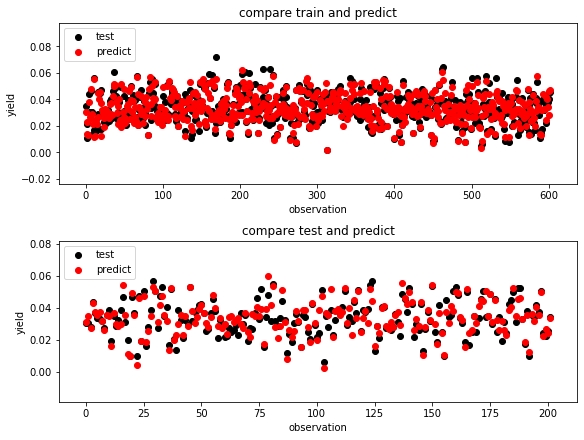

In [13]:
data_parameters = {}
model_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['file_parameters'] = ['ch', 'cv', 'cc']

data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 107
data_parameters['extra_parameters'] = ['bollsize', 'bollnum', 'bollvol']

data_parameters['one_hot_encoded_parameters'] = ['irrigation']

model_parameters['k_max'] = 500
model_parameters['verbose'] = 1
model_parameters['layer'] = [64]
model_parameters['dampconst'] = 2.7
model_parameters['dampfac'] = 0.02
model_parameters['E_stop'] = 0.005


#data Type
data_func = cottonYieldData

akashProcess(model_parameters, data_parameters, data_func)

(805, 6)
(805, 6)
(805, 6)
(805, 21)
(805,)
Iteration:  0 		Error:  445.78214910219697 	scale factor:  0.02
Iteration:  1 		Error:  0.5131560956766711 	scale factor:  0.007407407407407407
Iteration:  2 		Error:  0.020101612523093528 	scale factor:  0.0027434842249657062
Iteration:  3 		Error:  0.019166564251357602 	scale factor:  0.0027434842249657062
Iteration:  4 		Error:  0.018759440209702077 	scale factor:  0.0027434842249657062
Iteration:  5 		Error:  0.018525312813906417 	scale factor:  0.0027434842249657062
Iteration:  6 		Error:  0.018357106237425407 	scale factor:  0.0027434842249657062
Iteration:  7 		Error:  0.01822093137296381 	scale factor:  0.0027434842249657062
Iteration:  8 		Error:  0.018104358831572187 	scale factor:  0.0027434842249657062
Iteration:  9 		Error:  0.018001807308907214 	scale factor:  0.0027434842249657062
Iteration:  10 		Error:  0.017910215834335184 	scale factor:  0.0027434842249657062
Iteration:  11 		Error:  0.017827612138207768 	scale factor:  0.0

Iteration:  99 		Error:  0.016509201534126754 	scale factor:  0.001016105268505817
Iteration:  100 		Error:  0.01650721628815546 	scale factor:  0.001016105268505817
Iteration:  101 		Error:  0.016505231975483477 	scale factor:  0.001016105268505817
Iteration:  102 		Error:  0.016503246756273873 	scale factor:  0.001016105268505817
Iteration:  103 		Error:  0.0165012587691357 	scale factor:  0.001016105268505817
Iteration:  104 		Error:  0.01649926612787281 	scale factor:  0.001016105268505817
Iteration:  105 		Error:  0.016497266918173374 	scale factor:  0.001016105268505817
Iteration:  106 		Error:  0.01649525919422131 	scale factor:  0.001016105268505817
Iteration:  107 		Error:  0.016493240975220032 	scale factor:  0.001016105268505817
Iteration:  108 		Error:  0.016491210241812847 	scale factor:  0.001016105268505817
Iteration:  109 		Error:  0.016489164932378942 	scale factor:  0.001016105268505817
Iteration:  110 		Error:  0.016487102939201494 	scale factor:  0.00101610526850581

Iteration:  197 		Error:  0.0157852246484139 	scale factor:  0.00037633528463178407
Iteration:  198 		Error:  0.015772475623364368 	scale factor:  0.00037633528463178407
Iteration:  199 		Error:  0.01575982625574401 	scale factor:  0.00037633528463178407
Iteration:  200 		Error:  0.01574724795212279 	scale factor:  0.00037633528463178407
Iteration:  201 		Error:  0.015734722870975517 	scale factor:  0.00037633528463178407
Iteration:  202 		Error:  0.015722239578244493 	scale factor:  0.00037633528463178407
Iteration:  203 		Error:  0.01570979022666141 	scale factor:  0.00037633528463178407
Iteration:  204 		Error:  0.015697368731661006 	scale factor:  0.00037633528463178407
Iteration:  205 		Error:  0.015684969569793695 	scale factor:  0.00037633528463178407
Iteration:  206 		Error:  0.01568283555689715 	scale factor:  0.0001393834387525126
Iteration:  207 		Error:  0.015642660259909298 	scale factor:  0.0001393834387525126
Iteration:  208 		Error:  0.015619543488870362 	scale factor: 

Iteration:  293 		Error:  0.01420109379171032 	scale factor:  0.0001393834387525126
Iteration:  294 		Error:  0.014185651160949303 	scale factor:  0.0001393834387525126
Iteration:  295 		Error:  0.014171022492091208 	scale factor:  0.0001393834387525126
Iteration:  296 		Error:  0.01415708854581179 	scale factor:  0.0001393834387525126
Iteration:  297 		Error:  0.014143733923364177 	scale factor:  0.0001393834387525126
Iteration:  298 		Error:  0.014130848748579006 	scale factor:  0.0001393834387525126
Iteration:  299 		Error:  0.014118333082221277 	scale factor:  0.0001393834387525126
Iteration:  300 		Error:  0.014106101267455746 	scale factor:  0.0001393834387525126
Iteration:  301 		Error:  0.014094084563632137 	scale factor:  0.0001393834387525126
Iteration:  302 		Error:  0.014082231605991213 	scale factor:  0.0001393834387525126
Iteration:  303 		Error:  0.01407050693295942 	scale factor:  0.0001393834387525126
Iteration:  304 		Error:  0.01405888809540414 	scale factor:  0.0001

Iteration:  390 		Error:  0.01293812476494907 	scale factor:  0.0001393834387525126
Iteration:  391 		Error:  0.012927558050847854 	scale factor:  0.0001393834387525126
Iteration:  392 		Error:  0.012917003702836515 	scale factor:  0.0001393834387525126
Iteration:  393 		Error:  0.012906477263159704 	scale factor:  0.0001393834387525126
Iteration:  394 		Error:  0.01289599429353601 	scale factor:  0.0001393834387525126
Iteration:  395 		Error:  0.012885570298510033 	scale factor:  0.0001393834387525126
Iteration:  396 		Error:  0.012875220631942035 	scale factor:  0.0001393834387525126
Iteration:  397 		Error:  0.012864960378490976 	scale factor:  0.0001393834387525126
Iteration:  398 		Error:  0.012854804205109645 	scale factor:  0.0001393834387525126
Iteration:  399 		Error:  0.012844766188134394 	scale factor:  0.0001393834387525126
Iteration:  400 		Error:  0.012834859619681454 	scale factor:  0.0001393834387525126
Iteration:  401 		Error:  0.01282509680625137 	scale factor:  0.000

Iteration:  487 		Error:  0.012018393557478366 	scale factor:  5.162349583426392e-05
Iteration:  488 		Error:  0.012010118505333534 	scale factor:  5.162349583426392e-05
Iteration:  489 		Error:  0.012001879706051625 	scale factor:  5.162349583426392e-05
Iteration:  490 		Error:  0.011993685757591988 	scale factor:  5.162349583426392e-05
Iteration:  491 		Error:  0.011985544400677225 	scale factor:  5.162349583426392e-05
Iteration:  492 		Error:  0.011977462733889128 	scale factor:  5.162349583426392e-05
Iteration:  493 		Error:  0.011969447417612635 	scale factor:  5.162349583426392e-05
Iteration:  494 		Error:  0.011961504828247115 	scale factor:  5.162349583426392e-05
Iteration:  495 		Error:  0.011953641130709432 	scale factor:  5.162349583426392e-05
Iteration:  496 		Error:  0.011945862262072825 	scale factor:  5.162349583426392e-05
Iteration:  497 		Error:  0.011938173808097993 	scale factor:  5.162349583426392e-05
Iteration:  498 		Error:  0.011930580801727531 	scale factor:  5.

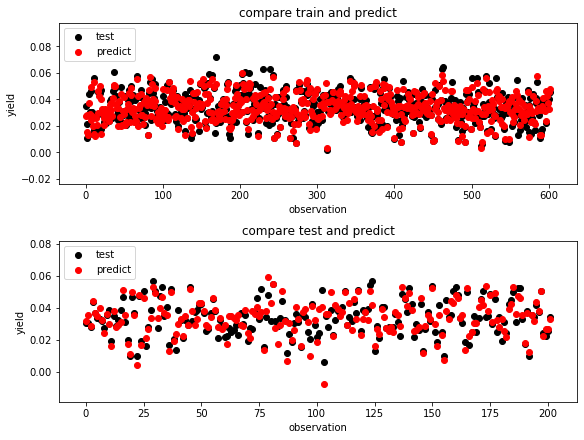

In [12]:
data_parameters = {}
model_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['file_parameters'] = ['ch', 'cv', 'cc']

data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 107
data_parameters['extra_parameters'] = ['bollsize']

data_parameters['one_hot_encoded_parameters'] = ['irrigation']

model_parameters['k_max'] = 500
model_parameters['verbose'] = 1
model_parameters['layer'] = [64]
model_parameters['dampconst'] = 2.7
model_parameters['dampfac'] = 0.02
model_parameters['E_stop'] = 0.005


#data Type
data_func = cottonYieldData

akashProcess(model_parameters, data_parameters, data_func)

In [19]:
#build model that have 2 hidden layers (64, 64)
def buildRegressionModel(model_shape, input_shape, optimizer, loss, metrics, drop_out=None, regularizer_l1=None, regularizer_l2=None, kernel_initializer = 'uniform', drop_out_rate = 0.25):

    # Define a Keras sequential model
    model = keras.Sequential()
    # Define the first dense layer
    for (i, size) in enumerate(model_shape):
        if i ==0:
            model.add(keras.layers.Dense(size, activation='relu', input_shape=[input_shape], kernel_regularizer=regularizer_l2,
                        activity_regularizer=regularizer_l1, kernel_initializer=kernel_initializer))
            if drop_out:
                model.add(keras.layers.Dropout(drop_out_rate))
        else:
            model.add(keras.layers.Dense(size, activation='relu', kernel_regularizer=regularizer_l2, kernel_initializer=kernel_initializer,
                        activity_regularizer=regularizer_l1))
            if drop_out:
                model.add(keras.layers.Dropout(drop_out_rate))
    model.add(keras.layers.Dense(1, kernel_initializer=kernel_initializer))
    
    #compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [20]:
def trainModel(x_data, y_data, input_shape, parameters):    
    #Build Hypterparameter
    sizes = parameters['sizes'] 
    shapes = parameters['shapes']
    drop_out = parameters['drop_out'] 
    regularizer_l1 = parameters['regularizer_l1']
    regularizer_l2 = parameters['regularizer_l2']
    kernel_initializer = parameters['kernel_initializer']
    drop_out_rate = parameters['drop_out_rate']
    #Compile Hyperparameter
    optimizer = parameters['optimizer']
    #optimizer = keras.optimizers.RMSprop(0.001)
    loss = parameters['loss']
    #loss = 'mae'
    metrics = parameters['metrics']

    #Callback Hyperparameter
    early_stopping = parameters['early_stopping']
    if early_stopping:
        callbacks = [early_stopping]
    else:
        callbacks = None
    verbose = parameters['verbose']
    
    #Train Hyperparameter
    epochs = parameters['epochs']
    validation_split = parameters['validation_split'] 
    
    #Test Train Split
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state = 90)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state = 90)
    
    histories ={}
    models = {}
    #build and train model
    for (i, size) in enumerate(sizes):
        models[size] = buildRegressionModel(shapes[i], input_shape, optimizer, loss, metrics, drop_out = drop_out, kernel_initializer = kernel_initializer, 
                                     regularizer_l1=regularizer_l1, regularizer_l2 =regularizer_l2)
        histories[size] = models[size].fit(x_train, y_train, epochs=epochs, validation_data=(x_valid, y_valid), 
                                  callbacks = callbacks, verbose = verbose)
        
        
    #plot results
    colors = ['red', 'blue', 'green', 'yellow']
    plt.figure()
    for i, size in enumerate(sizes):
        data_history = histories[size].history
        loss = data_history['loss']
        val_loss = data_history['val_loss']
        plt.plot(val_loss, color=colors[i], linestyle = '--', label = size + '_val_loss')
        plt.plot(loss, color=colors[i], linestyle = ':', label = size +'_loss')
    
    plt.legend(loc = 'upper left' )
    plt.xlabel = 'epochs'
    plt.ylabel = 'loss'
    
    
    #Show R2 scores
    for i, size in enumerate(sizes):
        #train score
        pred_train = models[size].predict(x_train)
        train_compare = pd.DataFrame({'y_train': y_train.flatten(), 'y_train_pred': pred_train.flatten()})
        train_r2_score = r2_score(train_compare.y_train, train_compare.y_train_pred)
        print(size + ' train r2 score = ', train_r2_score, '/ 1.0')
        
        #test score
        pred_test = models[size].predict(x_test)
        test_compare = pd.DataFrame({'y_test': y_test.flatten(), 'y_test_pred': pred_test.flatten()})
        test_r2_score = r2_score(test_compare.y_test, test_compare.y_test_pred)
        print(size+' test r2 score = ', test_r2_score, '/ 1.0')
        
    return (models, histories)

(802, 6)
(802, 6)
(802, 12)
(802, 15)
(802, 17)
(802, 17)
(802,)
default train r2 score =  0.7412299598478378 / 1.0
default test r2 score =  0.6707265232724129 / 1.0
medium train r2 score =  0.7547593692312067 / 1.0
medium test r2 score =  0.6656440464957959 / 1.0
small train r2 score =  0.7423326671344722 / 1.0
small test r2 score =  0.6679758132211238 / 1.0
tiny train r2 score =  0.7648554387172473 / 1.0
tiny test r2 score =  0.6834347407415284 / 1.0


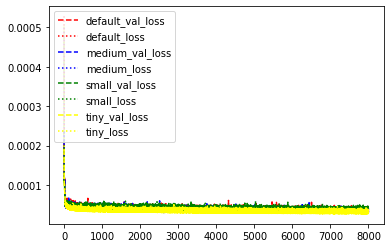

In [48]:
parameters = {}    
#Build Hypterparameter
parameters['sizes'] = ['default', 'medium', 'small', 'tiny']
# parameters['sizes'] = ['default', 'medium']
parameters['shapes'] = [[64,64,64,64], [64,64, 64], [64, 64], [64]]
# parameters['shapes'] = [[16,16]]
parameters['drop_out'] = True
parameters['regularizer_l1'] = None
parameters['regularizer_l2'] = None
parameters['kernel_initializer'] = 'uniform'
parameters['drop_out_rate'] = 0.001

#Compile Hyperparameter
parameters['optimizer'] = 'adam'
# parameters['optimizer'] = keras.optimizers.RMSprop(0.001)
parameters['loss'] = 'mse'
#loss = 'mae'
parameters['metrics'] = ['mse']

#Callback Hyperparameter
parameters['monitor'] = 'val_loss'
parameters['min_delta'] = 0.00001
parameters['patience'] = 5000
parameters['mode'] = 'min'
parameters['verbose'] = 0
parameters['restore_best_weights'] = True
# parameters['early_stopping'] = EarlyStopping(monitor=parameters['monitor'], min_delta=parameters['min_delta'], patience=parameters['patience'], mode=parameters['mode'], verbose=parameters['verbose'] , restore_best_weights = parameters['restore_best_weights'])
parameters['early_stopping'] = None

#Train Hyperparameter
parameters['epochs'] = 8000
parameters['validation_split'] = 0.2

data_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['date_chosen'] = ''
data_parameters['grnn'] = True
data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 105
data_parameters['remove_bad_yield'] = False
data_parameters['file_parameters'] = ['ch', 'cv']
data_parameters['extra_parameters'] = ['bollvol', 'bollnum', 'bollsize']
data_parameters['one_hot_encoded_parameters'] = ['irrigation']

#data Type
data_func = cottonYieldData

models, histories = process(parameters, data_parameters, data_func)